In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from scipy import stats
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import cm
from scipy.stats import hypergeom
from scdna_replication_tools.plot_utils import get_clone_cmap

In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

despine_offset = 10
despine_trim = True

### Load the table that shows the PERT cell cycle fractions vs the reported doubling times and scRNA cell cycle fractions

In [3]:
df = pd.read_csv('../../analysis/gastric_10x_500kb/sample_cell_cycle_counts.csv.gz')
df.head()

,dna_num_cells_s,dna_num_cells_g1,dna_frac_s,dna_frac_g1,cell_line,pert_g1g2_pct,pert_s_pct,doubling_time,dna_g0g1_pct,rna_g0g1_pct
0,309,587,0.344866,0.655134,HGC-27,65.513393,34.486607,17.046980,62.989011,28.307692
1,183,769,0.192227,0.807773,NCI-N87,80.777311,19.222689,46.935123,73.670330,71.824176
2,69,1149,0.056650,0.943350,SNU-668,94.334975,5.665025,73.959732,81.450549,71.692308


In [4]:
# create a list of y-axis columns to plot against 'pert_g1g2_pct'
x_cols = ['doubling_time', 'rna_g0g1_pct', 'doubling_time']
x_labels = ['Doubling time (h)', 'Andor scRNA G1%', 'Doubling time (h)']
y_cols = ['pert_g1g2_pct', 'pert_g1g2_pct', 'rna_g0g1_pct']
y_labels = ['PERT scWGS G1%', 'PERT scWGS G1%', 'Andor scRNA G1%']


def plot_pert_vs_andor_gastric_samples(df, x_cols, x_labels, y_cols, y_labels, ax):
    # plot the data
    i = 0
    for x_col, y_col in zip(x_cols, y_cols):
        # compute correlation coefficient between current x and y axes
        y = df[y_col]
        x = df[x_col]
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        # fit a regression line to the data but don't plot the points
        sns.regplot(y=y_col, x=x_col, data=df, ax=ax[i], scatter=False, color='black', line_kws={'alpha': 0.5}, ci=None)
        # plot the points colored by cell line
        sns.scatterplot(y=y_col, x=x_col, data=df, hue='cell_line', ax=ax[i])
        # adjust legend and axis labels
        ax[i].set_ylabel(y_labels[i])
        ax[i].set_xlabel(x_labels[i])
        # ax[i].legend(title='cell line')
        # report the correlation coefficient and p-value in the bottom right corner of the subplot
        ax[i].text(0.95, 0.05, 'r={:.2f}, p={:.2e}'.format(r_value, p_value), transform=ax[i].transAxes, horizontalalignment='right', verticalalignment='bottom')
        # set the x-axis limits to be 5% wider than the data
        left_lim = max(df[x_col].min() - 5, 0)
        right_lim = min(df[x_col].max() + 5, 100)
        ax[i].set_xlim(left=left_lim, right=right_lim)
        sns.despine(ax=ax[i], offset=despine_offset, trim=despine_trim)
        i += 1
    
    ax[0].legend(title='cell line', loc='upper left', frameon=False)
    ax[1].legend().remove()
    ax[2].legend().remove()

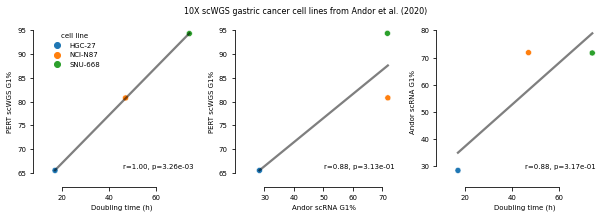

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(8.5, 3), tight_layout=True)

plot_pert_vs_andor_gastric_samples(df, x_cols, x_labels, y_cols, y_labels, ax)

fig.suptitle('10X scWGS gastric cancer cell lines from Andor et al. (2020)', fontsize=8)

fig.savefig('../../manuscript/extended_data_figs/figED8_top.pdf', dpi=300, bbox_inches='tight')

plt.show()

### Show the Muller plots and SPE vs expansion plots for the time-series hTERT cell lines

In [6]:
def timepoint_to_int(df):
    """Converts the timepoint column to an integer"""
    # get the timepoint column
    timepoints = df['timepoint'].values
    # convert the timepoints to integers
    timepoints = [int(x[1:]) for x in timepoints]
    # add the timepoints to the dataframe
    df['timepoint_int'] = timepoints
    # return the dataframe
    return df


def sort_timepoints(df):
    """Sort the dataframe according to clone_id and timepoint_int"""
    # if timepoint_int is not in the dataframe, create such a column
    df = timepoint_to_int(df)
    # sort the dataframe
    df = df.sort_values(by=['clone_id', 'timepoint_int'])
    # return the dataframe
    return df


def fill_in_missing_clones(df, clone_list=None):
    """ If there are clones present at some timepoints but not others, fill in the missing clones with 0s """
    # find the clone list if not specified
    if clone_list is None:
        clone_list = df.clone_id.unique()
    # loop through the clones and timepoints
    for clone in clone_list:
        for timepoint in df.timepoint.unique():
            # if the clone is not present at the timepoint, add a row with 0s
            if clone not in df[df.timepoint == timepoint].clone_id.values:
                new_line = pd.DataFrame({
                    'clone_id': [clone], 'timepoint': [timepoint], 'num_cells_s': [0], 'num_cells_g': [0],
                    'clone_frac_s': [0], 'clone_frac_g': [0], 'positive_p': [0], 'negative_p': [0],
                    'positive_p_adj': [0], 'negative_p_adj': [0], 'timepoint_int': [int(timepoint[1:])]
                })
                # concatenate the new line to the dataframe
                df = pd.concat([df, new_line], ignore_index=True)
    return df


def compute_clone_fracs_vs_time(df):
    """
    Computes the fraction of cells in each clone for each timepoint.
    """
    clone_frac_g_vs_time = np.zeros((len(df.clone_id.unique()), len(df.timepoint_int.unique())))
    clone_frac_s_vs_time = np.zeros((len(df.clone_id.unique()), len(df.timepoint_int.unique())))
    clone_legend = []
    timepoints = df.timepoint_int.unique()
    i = 0
    for clone_id, chunk in df.groupby('clone_id'):
        chunk.sort_values(by='timepoint_int', inplace=True)
        clone_frac_g_vs_time[i] = chunk['clone_frac_g'].values
        clone_frac_s_vs_time[i] = chunk['clone_frac_s'].values
        clone_legend.append(clone_id)
        i += 1
    return timepoints, clone_frac_g_vs_time, clone_frac_s_vs_time, clone_legend

In [7]:
def plot_clone_muller(df, dataset, ax_g, ax_s, interpolate=True, std=5, clone_cmap=get_clone_cmap()):
    """
    Plots the evolution of clones over time for each cell cycle phase. 
    """
    # split the dataframe based on cell cycle and find the fraction of cells in each clone at each timepoint for each cell cycle phase
    timepoints, clone_frac_g_vs_time, clone_frac_s_vs_time, clone_legend = compute_clone_fracs_vs_time(df)
    og_timepoints = timepoints

    if interpolate:
        clone_frac_g_vs_time = pd.DataFrame(clone_frac_g_vs_time, index=clone_legend, columns=timepoints)
        clone_frac_s_vs_time = pd.DataFrame(clone_frac_s_vs_time, index=clone_legend, columns=timepoints)
            
        # add columns with NaNs for the 0.5 intervals betweeen timepoints
        for i in range(min(timepoints), max(timepoints)):
            for frac in np.linspace(0.1, 0.9, 9):
                clone_frac_g_vs_time[i + frac] = np.nan
                clone_frac_s_vs_time[i + frac] = np.nan

        # sort the columns based on timepoint
        clone_frac_g_vs_time = clone_frac_g_vs_time.reindex(sorted(clone_frac_g_vs_time.columns), axis=1)
        clone_frac_s_vs_time = clone_frac_s_vs_time.reindex(sorted(clone_frac_s_vs_time.columns), axis=1)
        timepoints = clone_frac_g_vs_time.columns

        # # interpolate the NaNs
        # clone_frac_g_vs_time = clone_frac_g_vs_time.interpolate(method='spline', order=3, axis=1)
        # clone_frac_s_vs_time = clone_frac_s_vs_time.interpolate(method='spline', order=3, axis=1)
        clone_frac_g_vs_time = clone_frac_g_vs_time.T.rolling(len(timepoints), 1, True, 'gaussian').mean(std=std).T
        clone_frac_s_vs_time = clone_frac_s_vs_time.T.rolling(len(timepoints), 1, True, 'gaussian').mean(std=std).T
    
    # set x-axis ticks to all the timepoints we have measurements for
    ax_g.set_xticks(og_timepoints)
    ax_s.set_xticks(og_timepoints)

    clone_colors = [clone_cmap[x] for x in clone_legend]

    # plot as a stackplot
    baseline = 'zero'
    ax_g.stackplot(timepoints, clone_frac_g_vs_time, labels=clone_legend, baseline=baseline, colors=clone_colors)
    ax_s.stackplot(timepoints, clone_frac_s_vs_time, labels=clone_legend, baseline=baseline, colors=clone_colors)
    ax_g.set_ylabel('clone fraction')
    ax_g.set_xlabel('timepoint')
    ax_s.set_xlabel('timepoint')
    ax_g.set_title('{}: G1/2-phase'.format(dataset))
    ax_s.set_title('{}: S-phase'.format(dataset))
    # add a legend and move it to the left of the y-axis label
    ax_g.legend(title='clone', bbox_to_anchor=(-0.6, 1.2), frameon=False, ncol=2)
    # set the x-axis limits to be the very first and last timepoints
    ax_s.set_xlim(min(timepoints), max(timepoints))
    ax_g.set_xlim(min(timepoints), max(timepoints))

In [8]:
def plot_s_phase_enrichment(df, dataset, ax0, ax1, pt_size=5):
    # compute the maximum and minimum timepoints
    df['timepoint_ind'] = df['timepoint_int'].astype(int)
    max_time = df['timepoint_int'].max()
    min_time = df['timepoint_int'].min()

    pthresh = 1e-2

    # create custom legend for clones & timepoints
    clone_cmap = get_clone_cmap()
    viridis = cm.get_cmap('viridis', 256)
    timepoint_cmap = {}
    clone_legend_elements = [
        Line2D([0], [0], marker='^', color='w', label='enriched'.format(pthresh), markerfacecolor='k', markersize=pt_size),
        Line2D([0], [0], marker='v', color='w', label='depleted'.format(pthresh), markerfacecolor='k', markersize=pt_size)
    ]
    timepoint_legend_elements = clone_legend_elements.copy()
    for i, c in enumerate(sorted(df.clone_id.unique())):
        color = clone_cmap[c]
        # clone_legend_elements.append(Patch(facecolor=color, label=c))

    for i, t in enumerate(sorted(df.timepoint_int.unique())):
        color = viridis((t - min_time) / (max_time - min_time))
        timepoint_str = 'X{}'.format(t)
        timepoint_cmap[timepoint_str] = color
        # timepoint_legend_elements.append(Patch(facecolor=color, label=timepoint_str))

    # draw scatterplot comparing the relative fraction of each clone in S vs G1/2 phases
    for i, row in df.iterrows():
        clone_id = row['clone_id']
        timepoint = row['timepoint']
        if row['positive_p_adj'] < pthresh:
            ax0.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], color=clone_cmap[clone_id], marker='^', s=pt_size)
            ax1.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], color=timepoint_cmap[timepoint], marker='^', s=pt_size)
        elif row['negative_p_adj'] < pthresh:
            ax0.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], color=clone_cmap[clone_id], marker='v', s=pt_size)
            ax1.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], color=timepoint_cmap[timepoint], marker='v', s=pt_size)
        else:
            ax0.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], color=clone_cmap[clone_id], s=pt_size)
            ax1.scatter(x=row['clone_frac_g'], y=row['clone_frac_s'], color=timepoint_cmap[timepoint], s=pt_size)

    dataset = dataset.replace('_CISPLATIN_Combined', '')

    # ax0.legend(handles=clone_legend_elements, title='clone')
    # ax0.legend(handles=clone_legend_elements, title='S-phase', frameon=False, loc='lower right')
    ax0.set_title('{}: SPE'.format(dataset))
    ax1.set_title('{}: SPE'.format(dataset))
    ax0.set_ylabel('S fraction')
    for ax in [ax0, ax1]:
        ax.set_xlabel('G1/2 fraction')
        ax.set_xticks([0, 0.5, 1])
        ax.set_yticks([0, 0.5, 1])
    
    # draw y=x line where we expect "neutral" clones to lie
    lims = [
        np.min([ax0.get_xlim(), ax0.get_ylim()]),  # min of both axes
        np.max([ax0.get_xlim(), ax0.get_ylim()]),  # max of both axes
    ]
    ax0.plot(lims, lims, 'k--', alpha=0.25, zorder=0)
    ax1.plot(lims, lims, 'k--', alpha=0.25, zorder=0)

In [9]:
def filter_rows(df, num_cells=10):
    """Filters out rows that do not have a value for instantaneous_s or have few cells"""
    # convert SPE values with -inf to -12 and inf to 12
    df['SPE_score'] = df['SPE_score'].replace(-np.inf, -12)
    df['SPE_score'] = df['SPE_score'].replace(np.inf, 12)
    df = df.loc[df['SPE_score'].notna()]
    df = df.loc[df['instantaneous_s'].notna()]
    df = df.loc[df['num_cells_g'] > num_cells]
    return df


def add_instantaneous_s_and_enrichment(df):
    """Adds a column to the dataframe that contains the observed clone shift in G1/2 population for each clone at each timepoint"""
    # compute the enrichment or depletion for S-phase cells at a given timepoint
    df['clone_frac_diff'] = df['clone_frac_s'] - df['clone_frac_g']

    times = sorted(df.timepoint_int.unique())
    clones = sorted(df.clone_id.unique())

    # this column is a proxy for that clone's instatneous selection coefficient
    df['instantaneous_s'] = np.nan

    # find difference in a clone's number/fraction of cells between two adjacent timepoints
    for t in range(len(times)-1):
        for c in clones:
            t0 = times[t]
            t1 = times[t+1]
            # find the row that corresponds to this clone & time
            row_t0 = df.loc[(df['clone_id']==c) & (df['timepoint_int']==t0)]
            row_t1 = df.loc[(df['clone_id']==c) & (df['timepoint_int']==t1)]
            # find the difference in G1/2-phase fractions between t0 and t1
            frac_diff = row_t1['clone_frac_g'].values[0] - row_t0['clone_frac_g'].values[0]

            # add frac_diff to the dataframe at the appropriate row
            df.loc[(df['clone_id']==c) & (df['timepoint_int']==t0), 'instantaneous_s'] = frac_diff
    
    # compute the log10 value of positive_p so that we can plut this instead of clone_frac_diff
    df['log10_positive_p'] = np.log10(df['positive_p'])
    df['log10_negative_p'] = np.log10(df['negative_p'])

    # subtract the log10 positive_p from the log10 negative_p to create a new column named SPE score
    df['SPE_score'] = df['log10_negative_p'] - df['log10_positive_p']

    return df


def plot_s_predictiveness(df, ax, title=None, s=5):
    """Plots the observed clone shift in G1/2 population vs. the clone's S-phase enrichment/depletion"""
    # fit a regression line to the data
    sns.regplot(y='instantaneous_s', x='SPE_score', data=df, ax=ax, scatter=False, color='black', line_kws={'lw': 1})

    # rename columns clone_id to Clone ID and timepoint to Timepoint for plotting purposes
    df = df.rename(columns={'clone_id': 'clone ID'})

    # create a seaborn scatterplot comparing the observed clone shift in G1/2 population to the clone's S-phase enrichment/depletion
    sns.scatterplot(y='instantaneous_s', x='SPE_score', data=df, hue='clone ID', style='timepoint', palette=get_clone_cmap(), ax=ax, s=s)
    # set the y-axis label
    ax.set_ylabel('expansion score')
    # set the x-axis label
    ax.set_xlabel('SPE score')
    # set the title
    if title is not None:
        ax.set_title(title)

    # remove the legend
    ax.get_legend().remove()

    # expand the x axis limits to be slightly larger than the data
    ax.set_xlim(left=ax.get_xlim()[0] - 1, right=ax.get_xlim()[1] + 1)

    # # set the x axis limits to be -12 to 12
    # ax.set_xlim(-12, 12)

    # # set the y axis limits to be -1 to 1
    # ax.set_ylim(-1, 1)

    # # set the xaxis ticks from -10 to 10
    # ax.set_xticks([-10, 0, 10])

    # # set the yaxis ticks from -1 to 1
    # ax.set_yticks([-1, 0, 1])

In [10]:
def plot_all_fitness_samples(datasets, ax):
    """ Plot the Muller, S-phase enrichment, and S-predictiveness plots for all samples """
    for i, d in enumerate(datasets):
        # load the cell cycle clone counts for this dataset
        temp_df = pd.read_csv('../../analysis/fitness_lines_old/{}/cell_cycle_clone_counts.tsv'.format(d), sep='\t')

        # sort timepoints based on the timepoint_int column
        temp_df = sort_timepoints(temp_df)

        # find the set of clone_ids that appear in the union of the treated and untreated samples
        clone_list = list(set(temp_df.clone_id.unique()))
        # fill in missing clones with 0s
        temp_df = fill_in_missing_clones(temp_df, clone_list)

        # sort timepoints again now that we've added the earliest untreated timepoint and filled in missing clones
        temp_df = sort_timepoints(temp_df)

        # remove the _CISPLATIN_Combined suffix from the dataset name for SA535 datasets
        d = d.replace('_CISPLATIN_Combined', '')

        # plot clone fractions for each phase & timepoint in the form of a stackplot
        plot_clone_muller(temp_df, d, ax[i, 0], ax[i, 1], std=40)
        sns.despine(ax=ax[i, 0], offset=0, trim=despine_trim)
        sns.despine(ax=ax[i, 1], offset=0, trim=despine_trim)

        # plot the S-phase enrichment for each clone and timepoint
        plot_s_phase_enrichment(temp_df, d, ax[i, 2], ax[i, 3])
        sns.despine(ax=ax[i, 2], offset=0, trim=despine_trim)
        sns.despine(ax=ax[i, 3], offset=0, trim=despine_trim)

        # plot s predictiveness in the form of a scatterplot
        temp_df = sort_timepoints(temp_df)
        temp_df = add_instantaneous_s_and_enrichment(temp_df)
        temp_df = filter_rows(temp_df)
        plot_s_predictiveness(temp_df, ax[i, 4], title=d, s=8)
        sns.despine(ax=ax[i, 4], offset=0, trim=despine_trim)

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  app.launch_new_instance()
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encounter

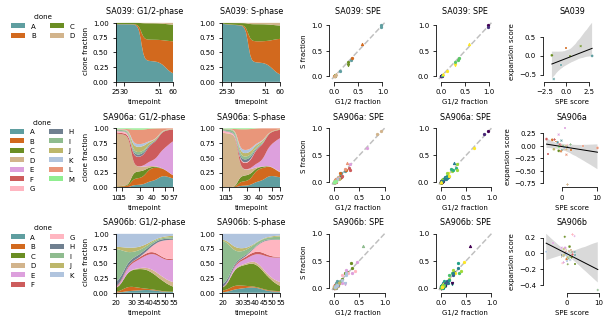

In [11]:
# create a 8.5 x 11 figure with 5 columns and 8 rows
fig, ax = plt.subplots(3, 5, figsize=(8.5, 4.5), tight_layout=True)

datasets = ['SA039', 'SA906a', 'SA906b']

plot_all_fitness_samples(datasets, ax)

fig.savefig('../../manuscript/extended_data_figs/figED8_bottom.pdf', dpi=300, bbox_inches='tight')

plt.show()